<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/File_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import packages and modules

In [1]:
# Necessry to run LGBMRegressor
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [2]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

!pip install tensorflow --upgrade
!pip install keras --upgrade

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [3]:
import pandas as pd
import numpy as np

from termcolor import colored
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os
from joblib import dump, load
import pandas as pd
import numpy as np
from scipy.stats import iqr, skew, kurtosis, mode
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
import seaborn as sns
sns.set_style("dark", {"grid.color": ".1", "grid.linestyle": ":", "axes.facecolor": ".9"})

from warnings import filterwarnings
from termcolor import colored
from warnings import filterwarnings; filterwarnings(action = 'ignore');
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss, \
                            mean_squared_error, mean_absolute_error, r2_score, \
                            make_scorer,root_mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, \
                                  OrdinalEncoder, OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.base import clone

from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, RepeatedStratifiedKFold, \
                                    cross_val_score, RepeatedKFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import k_means
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, mutual_info_classif, mutual_info_regression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingClassifier, StackingClassifier, VotingRegressor, StackingRegressor, \
                             RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, \
                             HistGradientBoostingClassifier, HistGradientBoostingRegressor \

from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import optuna
from optuna.samplers import TPESampler

import matplotlib as mpl


import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

In [4]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 768x576 with 0 Axes>

In [5]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
print("Keras backend:", keras.backend.backend())

Keras backend: tensorflow


# 2. Define Configuration and Data classes
In the code below we load the data and display some basic information about the dataset such as: the number of missing entries, the features types, and the number of unique categories per categorical feature.

In [8]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=15, shuffle=True, random_state=SEED)
    VERSION = '3'

class Data:
    path       = False
    or_path    = ''
    to_drop    = False
    target     = 'Price'

    def __init__(self):
        self.train      = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_train_enc_expanded.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_train_enc_expanded.csv")
        self.test       = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_test_enc_expanded.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_test_enc_expanded.csv",index_col=0)
        self.submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
        self.original   = pd.read_csv(self.or_path) if self.or_path else pd.DataFrame()

    @property
    def X(self):
        return self.train.drop(columns=self.target)
    @property
    def y(self):
        return self.train[[self.target]]
    @property
    def X_test(self):
        return self.test
    @property
    def X_original(self):
        if len(self.original) != 0:
            return self.original.drop(columns=self.target)
        return pd.DataFrame()
    @property
    def y_original(self):
        if len(self.original) != 0:
            return self.original[[self.target]]
        return pd.DataFrame()
    @property
    def cat_features(self):
        return self.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
    @property
    def num_features(self):
        return self.X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def submit(self, sub: np.ndarray, desc: str):
        '''Submit the predictions in the adequate format'''
        self.submission[self.target] = sub
        self.submission.to_csv(f'SUB_{CFG.VERSION}_{desc}.csv', index=False)
        print(colored('Submission has been made.', color='green', attrs=['bold', 'dark']))

    @staticmethod
    def sep_line():
        print(colored(f'{"_____"*14}', color='black'))
        print('')
    @staticmethod
    def head(head_text):
        print(colored(f'{"    "} ➩ {head_text} ', color='green', attrs=['dark']))

    def display_data(self):
        self.head(f'𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: {self.train.shape} | {self.test.shape}')
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝')
        display(self.train.head(5))
        self.head('𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝')
        display(self.test.head(5))
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨')
        display(self.train.info())
        self.head('𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨')
        display(self.test.info())
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.train.describe().T)
        self.head('𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.test.describe().T)
        self.sep_line()

        def nunique_null(train, test):
            nunique_train, nunique_test = {}, {}
            nulls_train, nulls_test = {}, {}

            for col in test.columns:
                nunique_train[col], nunique_test[col] = train[col].nunique(), test[col].nunique()
                nulls_train[col], nulls_test[col] = train[col].isna().sum(), test[col].isna().sum()

            df = pd.DataFrame([nunique_train, nunique_test,
                               nulls_train, nulls_test],
                              index=['Train nunique', 'Test nunique',
                                     'Train null', 'Test null'])
            return df

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬')
        display(nunique_null(self.train, self.test))
        self.sep_line()

        self.head('𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬')
        display(f'Train duplicated: {self.train.duplicated().sum()}')
        display(f'Test duplicated: {self.test.duplicated().sum()}')
        if self.train.duplicated().sum() > 0:
            self.train = self.train.drop_duplicates()
            print('Train duplicates dropped.')
        if self.test.duplicated().sum() > 0:
            #self.test = self.test.drop_duplicates()
            print('Test duplicates dropped.')
        self.sep_line()

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧')
        cat_cols = [c for c in self.test.columns if self.train[c].nunique() <= 40 or
                    c in self.test.select_dtypes(include=['object', 'category']).columns]

        def compare_unique_categories(train, test, cat_cols):
            unique_train_dic, unique_test_dic = {}, {}

            for c in cat_cols:
                unique_train_c = train[c].unique()
                unique_test_c = test[c].unique()

                count_tr = sum(1 for cat in unique_train_c if cat not in unique_test_c and not pd.isna(cat))
                count_te = sum(1 for cat in unique_test_c if (cat not in unique_train_c and not pd.isna(cat)))

                unique_train_dic[c] = count_tr
                unique_test_dic[c] = count_te

            result_df = pd.DataFrame([unique_train_dic, unique_test_dic],
                                     index=['in train not in test', 'in test not in train'])

            return result_df

        display(compare_unique_categories(self.train, self.test, cat_cols))

data = Data()
data.display_data()

     ➩ 𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: (3994318, 15) | (200000, 14) 
______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),TE_wc,skew_0,skew_1,cheap_flag,expansive_flag,Price
0,1,1,1,7,2,1,3,0,-0.917722,0.261445,-0.168518,-0.517618,0,0,112.15875
1,1,0,3,1,2,2,1,3,1.300573,0.621130,-0.846883,-0.613824,0,0,68.88056
2,5,1,3,2,2,1,1,6,-0.196013,0.016408,-0.606337,-1.382314,0,0,39.17320
3,3,3,3,8,2,1,1,3,-0.727615,1.498987,-0.606337,-0.709550,0,0,80.60793
4,0,0,1,0,2,2,1,3,-0.037447,0.016408,-1.185578,0.754615,0,0,86.02312


     ➩ 𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),TE_wc,skew_0,skew_1,cheap_flag,expansive_flag
0,4,1,3,2,1,1,3,3,0.381607,0.414531,1.019273,0.544976,0,0
1,3,0,1,7,1,2,0,3,-0.637706,-0.095293,0.268810,-0.100777,0,0
2,0,0,0,9,1,2,1,1,-0.889313,2.164135,0.044250,1.660423,0,0
3,0,3,0,0,2,1,1,3,0.066921,-0.516258,-0.385691,1.131928,0,0
4,2,3,0,2,2,2,3,0,-1.162081,0.016408,-1.749252,0.496019,0,0


______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 int64  
 1   Material              int64  
 2   Size                  int64  
 3   Compartments          int64  
 4   Laptop Compartment    int64  
 5   Waterproof            int64  
 6   Style                 int64  
 7   Color                 int64  
 8   Weight Capacity (kg)  float64
 9   TE_wc                 float64
 10  skew_0                float64
 11  skew_1                float64
 12  cheap_flag            int64  
 13  expansive_flag        int64  
 14  Price                 float64
dtypes: float64(5), int64(10)
memory usage: 457.1 MB


None

     ➩ 𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 200000 non-null  int64  
 1   Material              200000 non-null  int64  
 2   Size                  200000 non-null  int64  
 3   Compartments          200000 non-null  int64  
 4   Laptop Compartment    200000 non-null  int64  
 5   Waterproof            200000 non-null  int64  
 6   Style                 200000 non-null  int64  
 7   Color                 200000 non-null  int64  
 8   Weight Capacity (kg)  200000 non-null  float64
 9   TE_wc                 200000 non-null  float64
 10  skew_0                200000 non-null  float64
 11  skew_1                200000 non-null  float64
 12  cheap_flag            200000 non-null  int64  
 13  expansive_flag        200000 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 

None

______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Brand,3994318.0,2.584763e+00,1.843070,0.000000,1.000000,3.000000,4.000000,5.000000
Material,3994318.0,2.070342e+00,1.562931,0.000000,1.000000,3.000000,4.000000,4.000000
Size,3994318.0,1.314194e+00,1.222013,0.000000,0.000000,1.000000,3.000000,3.000000
Compartments,3994318.0,4.435745e+00,2.881279,0.000000,2.000000,4.000000,7.000000,9.000000
Laptop Compartment,3994318.0,1.469268e+00,0.546253,0.000000,1.000000,1.000000,2.000000,2.000000
Waterproof,3994318.0,1.469387e+00,0.544327,0.000000,1.000000,1.000000,2.000000,2.000000
Style,3994318.0,1.359897e+00,1.229806,0.000000,0.000000,1.000000,3.000000,3.000000
Color,3994318.0,2.898823e+00,2.082539,0.000000,1.000000,3.000000,5.000000,6.000000
Weight Capacity (kg),3994318.0,-4.068731e-09,1.000000,-1.865994,-0.851663,0.006300,0.856963,1.719577
TE_wc,3994318.0,-9.840794e-11,1.000000,-6.903976,-0.471265,0.016408,0.451310,6.731979


     ➩ 𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Brand,200000.0,2.583635,1.845064,0.000000,1.000000,3.000000,4.000000,5.000000
Material,200000.0,2.074010,1.560463,0.000000,1.000000,3.000000,4.000000,4.000000
Size,200000.0,1.315085,1.222397,0.000000,0.000000,1.000000,3.000000,3.000000
Compartments,200000.0,4.443590,2.879623,0.000000,2.000000,4.000000,7.000000,9.000000
Laptop Compartment,200000.0,1.468485,0.546469,0.000000,1.000000,1.000000,2.000000,2.000000
Waterproof,200000.0,1.468915,0.545110,0.000000,1.000000,1.000000,2.000000,2.000000
Style,200000.0,1.359800,1.230834,0.000000,0.000000,1.000000,3.000000,3.000000
Color,200000.0,2.901365,2.081725,0.000000,1.000000,3.000000,5.000000,6.000000
Weight Capacity (kg),200000.0,-0.002493,0.999763,-1.865994,-0.852032,0.006356,0.854115,1.719577
TE_wc,200000.0,0.000134,1.000090,-6.756299,-0.475368,0.016408,0.452854,6.500204


______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),TE_wc,skew_0,skew_1,cheap_flag,expansive_flag
Train nunique,6,5,4,10,3,3,4,7,907130,1803800,36,72,2,2
Test nunique,6,5,4,10,3,3,4,7,108681,78292,36,72,2,2
Train null,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test null,0,0,0,0,0,0,0,0,0,0,0,0,0,0


______________________________________________________________________

     ➩ 𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬 


'Train duplicated: 0'

'Test duplicated: 1'

Test duplicates dropped.
______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,skew_0,cheap_flag,expansive_flag
in train not in test,0,0,0,0,0,0,0,0,0,0,0
in test not in train,0,0,0,0,0,0,0,0,0,0,0


In [9]:
data.X.shape, data.y.shape, data.X_test.shape

((3994318, 14), (3994318, 1), (200000, 14))

In [10]:
print(data.cat_features)

['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'cheap_flag', 'expansive_flag']


In [11]:
data.X.info(),data.X_test.info(),

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 int64  
 1   Material              int64  
 2   Size                  int64  
 3   Compartments          int64  
 4   Laptop Compartment    int64  
 5   Waterproof            int64  
 6   Style                 int64  
 7   Color                 int64  
 8   Weight Capacity (kg)  float64
 9   TE_wc                 float64
 10  skew_0                float64
 11  skew_1                float64
 12  cheap_flag            int64  
 13  expansive_flag        int64  
dtypes: float64(4), int64(10)
memory usage: 426.6 MB
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 200000 non-null  int64  
 1   Materia

(None, None)

# 3. Data Preprocessing
Here we define a preprocessing class to handle missing values and perform some feature engineering.

In [12]:
class Preprocessing:
    def __init__(self, data: Data):
        self.data = data

    def feature_preparation(self):
        ''' User-define feature engineering and preprocessing'''
        print('⇒ Train-Test-Original shapes before preprocessing:',
              self.data.train.shape, self.data.test.shape, self.data.original.shape)

        df = pd.concat([self.data.train, self.data.test, self.data.original], axis=0)
        ## -- Operations
        # Convert categoricals and handle missing
        df = self.convert_categorical(df)
        df = self.handle_nan(df)

        # Retrieve train, test and original
        self.data.train    = df[:len(self.data.train)].reset_index(drop=True)
        self.data.test     = df[len(self.data.train):len(self.data.train)+\
                                len(self.data.test)].reset_index(drop=True).drop(columns=data.target)
        self.data.original = df[len(self.data.train)+len(self.data.test):].reset_index(drop=True)
        print('⇒ Train-Test-Original shapes after preprocessing:', self.data.train.shape, self.data.test.shape, self.data.original.shape)
        print('⇒ Preprocessing finished')

    @staticmethod
    def convert_categorical(df):
        '''For converting data to categoricals'''
        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].astype(str).fillna('missing').astype('int')
        return df

    @staticmethod
    def handle_nan(df):
        for c in df.select_dtypes(exclude=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].median())

        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].mode()[0])

        return df

    @staticmethod
    def calculate_fi():

        def sorted_fi(fi): # fi is a list of feature importances
            fi = list(zip(data.X.columns.to_list(), fi))
            return sorted(fi, key=lambda x: x[1], reverse=True)

        # Make a pipeline to transform X for those method which can't handle categorical and NaN natively
        pipe    = make_pipeline(SimpleImputer(strategy='most_frequent'), CountEncoder(), StandardScaler())
        X_FE    = pipe.fit_transform(data.X)

        FI_LGBM = sorted_fi(LGBMRegressor(verbose=-1, random_state=CFG.SEED).fit(data.X, data.y).feature_importances_)

        FI_CB   = sorted_fi(CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features).fit(data.X, data.y).get_feature_importance())

        FI_RF   = sorted_fi(RandomForestRegressor(n_estimators=100, random_state=CFG.SEED).fit(X_FE, data.y).feature_importances_)

        FI_MI   = sorted_fi(list(mutual_info_regression(X_FE, data.y)))

        FIS     = [FI_LGBM, FI_CB, FI_RF, FI_MI]
        titles  = ['LGBM FI', 'CB FI', 'RF FI', 'MI']

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 10))
        for i, FI in enumerate(FIS):
            # Convert the list of tuples to a DataFrame for easier plotting
            FI_df = pd.DataFrame(FI[:15], columns=['Feature', 'Importance'])
            sns.barplot(x='Importance', y='Feature', data=FI_df, ax=axes[i], palette='Blues_r')
            axes[i].set_title(titles[i])

        plt.tight_layout()
        plt.show()


data = Data()
pp   = Preprocessing(data)
pp.feature_preparation()
#pp.calculate_fi()

⇒ Train-Test-Original shapes before preprocessing: (3994318, 15) (200000, 14) (0, 0)
⇒ Train-Test-Original shapes after preprocessing: (3994318, 15) (200000, 14) (0, 15)
⇒ Preprocessing finished


In [13]:
data.cat_features,data.num_features

(['Brand',
  'Material',
  'Size',
  'Compartments',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color',
  'cheap_flag',
  'expansive_flag'],
 ['Weight Capacity (kg)', 'TE_wc', 'skew_0', 'skew_1'])

In [14]:
data.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 int64  
 1   Material              int64  
 2   Size                  int64  
 3   Compartments          int64  
 4   Laptop Compartment    int64  
 5   Waterproof            int64  
 6   Style                 int64  
 7   Color                 int64  
 8   Weight Capacity (kg)  float64
 9   TE_wc                 float64
 10  skew_0                float64
 11  skew_1                float64
 12  cheap_flag            int64  
 13  expansive_flag        int64  
dtypes: float64(4), int64(10)
memory usage: 426.6 MB


We can observe that there is no consensus among the different methods to the most important features. 'MI' entry, which stands for the calculation from Mutual Information method, seems quite reasonable: the Overall quality of the house is the most important feature, followed by the Neighborhood, which ultimately reflects its location.

# 4. Modeling

### 4.0 Neural Network Model Functions:

In [ ]:
cat_features_card = []
for f in data.cat_features:
  cat_features_card.append(1 + data.X[f].astype("int").max())

cat_features_card

In [22]:
#####################################################################################################################################################################################
def build_model_v0(units=512,last_layer = 1, activation="relu",cat_features=data.cat_features,cat_features_card=cat_features_card):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(int(units/last_layer), activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

#####################################################################################################################################################################################
def build_model_v1(units=512,last_layer = 1, activation="relu", cat_features=data.cat_features,cat_features_card=cat_features_card, dropout_rate=0.35, reg=0.001):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    # Reshape for the Attention layer.  Crucial for keras.layers.Attention
    # The Attention layer expects 3D tensors. Even if your "sequence"
    # length is 1, you MUST add a dimension.

    reshaped_features = layers.Reshape((1, -1))(x)

    attention_output = layers.Attention()([reshaped_features, reshaped_features])  # Self-attention

    # Flatten the attention output:
    flattened_attention = layers.Flatten()(attention_output)

    # Concatenate with original features (optional but often helpful):
    x = layers.Concatenate(axis=-1)([x, flattened_attention])

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

#####################################################################################################################################################################################
def build_model_v2(units=512, last_layer=1, activation="relu", cat_features=data.cat_features,cat_features_card=cat_features_card,
                   repeat_att=2, dropout_rate=0.2, num_transformer_heads=4, transformer_units=64, reg=0.0001): # Reduced transformer_units

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    transformer_outputs = [] # List to store transformer outputs for each categorical feature

    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:, j])
        x = layers.Flatten()(x)
        x = layers.Dropout(dropout_rate)(x)
        embs.append(x)

        # Reshape for Transformer (batch_size, 1, features) - Crucial!
        reshaped_embedding = layers.Reshape((1, -1))(x)

        # Transformer Layer for each categorical feature
        for q in list(range(repeat_att)):
          if q == 0:
            attention_output = reshaped_embedding

          attention_output_ = layers.MultiHeadAttention(num_heads=num_transformer_heads, key_dim=transformer_units,name=f"mh_{j}_{q}")(attention_output, attention_output)
          attention_output_ = layers.LayerNormalization(name=f"mh_ln1_{j}_{q}")(attention_output + attention_output_) #ResNet_1
          attention_output_ = layers.Dense(reshaped_embedding.shape[-1], activation=activation,name=f"mh_dense_{j}_{q}")(attention_output_)
          attention_output = layers.LayerNormalization(name=f"mh_ln2_{j}_{q}")(attention_output + attention_output_) #ResNet_1

        transformer_outputs.append(layers.Flatten()(attention_output)) # Store flattened transformer output

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    # Reshape for the Attention layer.  Crucial for keras.layers.Attention
    # The Attention layer expects 3D tensors. Even if your "sequence"
    # length is 1, you MUST add a dimension.

    x_orig = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    reshaped_features = layers.Reshape((1, -1))(x_orig)

    attention_output = layers.Attention()([reshaped_features, reshaped_features])  # Self-attention

    # Flatten the attention output:
    flattened_attention = layers.Flatten()(attention_output)

    # Concatenate with original features (optional but often helpful):
    x = layers.Concatenate(axis=-1)([x_orig, flattened_attention])

    # Concatenate Transformer outputs and numerical features
    all_features = layers.Concatenate(axis=-1)(transformer_outputs + [x])

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(all_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(int(units/last_layer), activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    #x = layers.Concatenate(axis=-1)([x_orig, x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

  ####################################################

class exitesqueeze_layer(layers.Layer):
    def __init__(self, exite_units,dropout_rate,activation,reg):
        super().__init__()

        self.exite_units = exite_units
        self.activation=activation
        self.reg=reg

        self.reshaped_0 = layers.Reshape((-1, 1))
        self.reshaped_1 = layers.Reshape((-1, ))

        self.exite = layers.Dense(self.exite_units, activation=self.activation)
        self.squeeze = layers.Dense(1, activation="linear",kernel_regularizer=keras.regularizers.l2(reg))
        self.lnorm_00 = layers.LayerNormalization()
        self.lnorm_01 = layers.LayerNormalization()
        self.drop = layers.Dropout(rate=dropout_rate)
        self.attention = layers.Attention()

    def call(self, inputs):
        x = self.reshaped_0(inputs)
        x = self.exite(x)
        att_out = self.attention([x,x])
        att_out = self.lnorm_00(att_out)
        x = layers.add([x, att_out])
        x = self.squeeze(x)
        x = self.reshaped_1(x)

        x = layers.multiply([x, inputs])

        x = self.lnorm_01(x)
        x = self.drop(x)

        return x

    # Remove build warnings
    def build(self):
        self.built = True


def build_model_v3(units=512,exite_units=64, last_layer = 1, activation="relu", reg=0.001, dropout_rate=0.33):

    x_input_cats = layers.Input(shape=(len(data.cat_features),))
    embs = []
    for j in range(len(data.cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x_0 = layers.Concatenate(axis=-1, name="input_concat")(embs+[x_input_nums])

    es_0 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x_0)

    x = layers.Concatenate(axis=-1, name="se_0_concat")([x_0,es_0])
    x = layers.BatchNormalization(name="se_0_bn")(x)

    es_1 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_1_concat")([x,es_1])
    x = layers.BatchNormalization(name="se_1_bn")(x)

    es_2 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_2_concat")([x,es_2])
    x = layers.BatchNormalization(name="se_2_bn")(x)

    x_0 = layers.Dense(units, name="dense_0", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_0")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_0")(x_0)

    x_0 = layers.Dense(int(units/last_layer), name="dense_1", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_1")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_1")(x_0)

    x = layers.Concatenate(axis=-1)([x_0,x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

### 4.1 Stacking

In [25]:
class TrainModels:
    def __init__(self, X, y, X_test, X_original, y_original, models):
        self.models     = models
        self.X          = X
        self.y          = y
        self.X_original = X_original
        self.y_original = y_original
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(include=['float']).columns.to_list()

    @staticmethod
    def convert_cat(df_):
        '''
        A function to convert dtypes to categorical if the catboost with all categorical
        features is called
        '''
        df = df_.copy()
        for c in df.columns.to_list():
            df[c] = df[c].astype(str).astype('category')
        return df


    def fit_model(self, name, model_, train_flag):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        CB_CAT_FLAG = True if 'CB_CAT' in name.upper() else False

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E2/layers_3_staked_models_opt')

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]

            # Adds the original data to training set only
            if self.X_original is not None:
                x_train = pd.concat([x_train, self.X_original], axis=0)
                y_train = pd.concat([y_train, self.y_original], axis=0)

            # -- Create a special block to convert all features to categorical
            if CB_CAT_FLAG:
                x_train = self.convert_cat(x_train)
                x_val   = self.convert_cat(x_val)
            if 'NN_' in name.upper():
              model = model_
            else:
              model = clone(model_)

#######################################################################################
            if 'NN_' in name.upper():

              model = model_

              X_train_cat = x_train[self.categorical_features].astype("int32")
              X_train_num = x_train[self.numerical_features].astype("float")

              X_valid_cat = x_val[self.categorical_features].astype("int32")
              X_valid_num = x_val[self.numerical_features].astype("float32")

              X_test_cat = self.X_test[self.categorical_features].astype("int32")
              X_test_num = self.X_test[self.numerical_features].astype("float32")

              # Compile the model
              keras.utils.set_random_seed(42)

              optimizer = keras.optimizers.Adam(learning_rate=1e-3)
              model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mse"),
                            metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])

              # Fit the model
              if train_flag==True:
                model.fit([X_train_cat,X_train_num], y_train,
                          validation_data=([X_valid_cat, X_valid_num], y_val),
                          epochs=101,
                          batch_size=2048,
                          callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, monitor="val_rmse", factor=0.3, min_lr=5e-5),
                                     keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmse",
                                                                    start_from_epoch=3, mode="min")])

                model.save(f'{name}_{CFG.VERSION}.keras') # Saving the model after training

              else:
                print("Load Model")
                model = load(f'{name}_{CFG.VERSION}.keras') # Loading the saved model
#####################################################################################

            elif 'CB' in name.upper():
              if train_flag==True:
                model.fit(x_train,y_train,eval_set=[(x_val,y_val)], early_stopping_rounds=101)
                model.save_model(f"{name}_{fold}_{CFG.VERSION}.bin")
              else:
                print("Load Model")
                model = CatBoostRegressor()
                model.load_model(f"{name}_{fold}_{CFG.VERSION}.bin")

            elif 'LGBMR' in name.upper():
              early_stop = early_stopping(stopping_rounds=101)
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stop],categorical_feature=self.categorical_features)
                model.booster_.save_model(f'{name}_{fold}_{CFG.VERSION}.txt')
              else:
                print("Load Model")
                model = lgb.Booster(model_file=f'{name}_{fold}_{CFG.VERSION}.txt')

            elif 'LGBMP' in name.upper():
              # Fit the model
              if train_flag==True:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}_{CFG.VERSION}.pkl')
              else:
                print("Load Model")
                model = load(f'{name}_{fold}_{CFG.VERSION}.pkl')

            elif 'XGBR' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)
                model.save_model(f'{name}_{fold}_{CFG.VERSION}.json')
              else:
                print("Load Model")
                model = XGBRegressor()  # Create an instance of the model
                model.load_model(f'{name}_{fold}_{CFG.VERSION}.json')

            elif 'LGBM_2' in name.upper():
              model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)


            elif 'HGB_' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}_{CFG.VERSION}.pkl')
              else:
                print("Load Model")
                model = load(f'{name}_{fold}_{CFG.VERSION}.pkl')

            else:

              model.fit(x_train, y_train)


            #################### Predictions
            if 'NN_' in name.upper():
              y_pred_train = model.predict([X_train_cat,X_train_num], batch_size=1024).ravel()
              y_pred_val   = model.predict([X_valid_cat, X_valid_num], batch_size=1024).ravel()
              y_pred_test  = model.predict([X_test_cat, X_test_num], batch_size=1024).ravel()

            else:
              y_pred_train = model.predict(x_train).ravel()
              y_pred_val   = model.predict(x_val).ravel()
              y_pred_test  = model.predict(self.X_test if not CB_CAT_FLAG else self.convert_cat(self.X_test)).ravel()

            oof_train[val_idx] = y_pred_val
            oof_test   += y_pred_test/CFG.CV.get_n_splits()

            train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))
            val_score   = np.sqrt(mean_squared_error(y_val, y_pred_val))

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    def fit_models(self):
        for name, model in list(self.models.items()):
            print(colored(f'{" "*4} Fitting {name}', color='red', attrs=['dark', 'bold']))
            self.fit_model(name, model[0], model[1])
            print("")

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

#### 4.1.1 First Level of Stacking
We define a bunch of tree-based methods with many different hyperparameters configurations to aggregate diversity.

In [26]:
os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

In [27]:
lgbm_params_1 = {'num_leaves': 103, 'min_child_samples': 36, 'subsample': 0.9131771240297577, 'subsample_freq': 2, 'colsample_bytree': 0.6190291906152294, 'reg_alpha': 0.03976551748855951, 'reg_lambda': 0.2576052197300848}
#lgbm_params_5 = {'max_depth': 5, 'learning_rate': 0.055, 'n_estimators': 3000, 'num_leaves': 31}
#lgbm_params_6 = {'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 3000, 'num_leaves': 31}
#lgbm_params_6 = {'max_depth': 9, 'learning_rate': 0.02, 'n_estimators': 2000, 'num_leaves': 31, "subsample":0.85, "colsample_bytree":0.85,
#                 "reg_alpha":0.01, "reg_lambda":0.01, "boosting_type":"gbdt" }

cb_cat_params_1   = {'iterations': 3000,'learning_rate': 0.025,'depth': 9, 'l2_leaf_reg': 0.004177701145518355,
                     'bagging_temperature': 0.5, 'random_strength': 0.5,"bootstrap_type": "Bayesian",
                     'cat_features': data.cat_features,'task_type': 'GPU',
                     'random_seed':CFG.SEED,'verbose': 250,"od_type":'EBS',"od_wait":101,"use_best_model":True}

xgb_params_1 = {'n_estimators': 3000,'learning_rate': 0.025,'max_depth': 9,'min_child_weight': 9,'subsample': 0.95,'colsample_bytree': 0.75,
                'gamma': 0.5511841320880777,'reg_alpha': 0.006948944983035811,'reg_lambda': 0.0015661314558322087,
                'objective': "reg:squarederror",'eval_metric': "rmse", "early_stopping_rounds":101, 'device':'gpu', 'tree_method': 'gpu_hist',
                'random_state': CFG.SEED,'enable_categorical': True,"verbosity":0}

nn_params_v0 = {'units': 1024, 'last_layer': 2, 'activation': 'silu'}
nn_params_v1 = {'units': 512, 'last_layer': 1, 'activation': 'relu', 'reg': 0.0002133354415296107, 'dropout_rate': 0.47090232042440616}
nn_params_v2 = {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}

models={
#        'LGBMR1_opt': [LGBMRegressor(learning_rate=0.02,boosting_type='gbdt',n_estimators=3000,objective="regression",eval_metric="rmse",device='gpu',verbose=-1,random_state= CFG.SEED,**lgbm_params_1),False],
        #'LGBMR2': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, boosting_type='dart', device='gpu',n_estimators=211),False],
        #'LGBMR3': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, data_sample_strategy='GOSS', device='gpu',n_estimators=211),False],
        #'LGBMP4': [make_pipeline(CatBoostEncoder(), LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_4, device='gpu')),False],
        #'LGBMR5': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_5, device='gpu'),False],
        #'LGBMR6': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_6, device='gpu'),False],

#        'CB1_opt'   :[CatBoostRegressor(objective="RMSE",eval_metric="RMSE", **cb_cat_params_1),False],
    #    'CB2'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, grow_policy='Depthwise', loss_function='RMSE', task_type='GPU', iterations=3000),False],
    #    'CB3'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, grow_policy='Lossguide', loss_function='RMSE', task_type='GPU', iterations=3000),False],
    #    'CB4'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, **cb_cat_params_4, loss_function='RMSE', task_type='GPU', iterations=3000),False],
    #    'CB5'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, iterations=3000, task_type='GPU'),False],
    #   'CB_CAT1': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), iterations=750, task_type='GPU'),True],
    #    'CB_CAT2': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), **cb_cat_params_4, loss_function='RMSE', task_type='GPU'),True],

#        'XGBR1_opt' : [XGBRegressor(**xgb_params_1),False],
    #   'XGBR2' : [XGBRegressor(random_state=CFG.SEED, enable_categorical=True, max_depth=4, learning_rate=0.04, device='gpu', early_stopping_rounds=101,tree_method= 'gpu_hist',n_estimators=2000),True],


#        'HGB_TE': [make_pipeline(TargetEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
#                                                                              learning_rate=0.035, max_depth=8,validation_fraction=0.15,
#                                                                              early_stopping=True, l2_regularization=0.03,
#                                                                             )),False],

      #  'HGB_CE': [make_pipeline(CountEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
      #                                                                          learning_rate=0.055, max_depth=5,
      #                                                                          early_stopping=True,  validation_fraction=0.15
      #                                                                        )),True],

#        "NN_v0" : [build_model_v0(**nn_params_v0),True],
#        "NN_v1" : [build_model_v1(**nn_params_v1),True],
        "NN_v2" : [build_model_v3(**nn_params_v2),True]}

TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

     Fitting NN_v2
Epoch 1/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - loss: 3448.5542 - rmse: 57.3162 - val_loss: 1499.6984 - val_rmse: 38.7254 - learning_rate: 0.0010
Epoch 2/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1514.1229 - rmse: 38.9112 - val_loss: 1499.1476 - val_rmse: 38.7182 - learning_rate: 0.0010
Epoch 3/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1505.7306 - rmse: 38.8031 - val_loss: 1498.7871 - val_rmse: 38.7135 - learning_rate: 0.0010
Epoch 4/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1502.0063 - rmse: 38.7550 - val_loss: 1498.9771 - val_rmse: 38.7159 - learning_rate: 0.0010
Epoch 5/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1500.4741 - rmse: 38.7352 - val_loss: 1499.0582 - val_rmse: 38.7169 - learning_rate: 0.0010
Epoch 6/101
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1499.5563 - rmse: 38.7233 - val_loss: 1499.3561 - val_rmse: 38.7207 - learning_rate: 0.0010
Epoch 7/101
1821/1821 ━━━━━━━━━━━━━━━━━

#### 4.1.2 Second Level of Stacking
We take the out-of-folds predictions from the previous models and fed them into simple linear methods like Ridge and Lasso. The alpha parameters have been tuned manually (i.e., trial and error).

In [ ]:
models2 = {
          'Ridge2': Ridge(alpha=1),
          'Lasso2': Lasso(alpha=0.0002),
          'LGBM_2' : LGBMRegressor(max_depth=2, random_state=CFG.SEED, verbose=-1, device='gpu'),
          }

TM2 = TrainModels(X=TM.OOF_train, y=data.y, X_test=TM.OOF_test, X_original=None, y_original=None, models=models2)
TM2.fit_models()
data.submit(sub=TM2.OOF_test.mean(axis=1), desc='lasso_ridge_mean')

#### 4.1.3 Third Level of Stacking
At this stage, the first level and second level out-of-fold predictions are incorporated into the original training data. This is then fed into another level of models to output the final stage of out-of-fold predictions which are finally averaged.

In [ ]:
train = pd.concat([data.X,      TM.OOF_train, TM2.OOF_train], axis=1)
test  = pd.concat([data.X_test, TM.OOF_test,  TM2.OOF_test], axis=1)

models3 = {
          'LGBM_21' : LGBMRegressor(verbose=-1, random_state=CFG.SEED, max_depth=4, device='gpu'),
          'CB_3'   : CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, task_type='GPU'),
          'Ridge_3': make_pipeline(TargetEncoder(), Ridge(alpha=5)),
          'Lasso_3': make_pipeline(TargetEncoder(), Lasso(alpha=0.001)),
          }

TM3  = TrainModels(X=train, y=data.y, X_test=test, X_original=None, y_original=None, models=models3)
TM3.fit_models()

TM3.save_predictions()

In [ ]:
data.submit(sub=TM3.OOF_test.mean(axis=1), desc='final_layer')

Submission has been made.


In [ ]:
TM3.OOF_test.mean(axis=1)

,0
0,81.828801
1,81.913722
2,88.117746
3,78.654571
4,80.203378
...,...
199995,83.698665
199996,79.667135
199997,83.700374
199998,82.015075


In [ ]:
TM3.save_predictions()

In [ ]:
TM3.OOF_test.mean(axis=1)
Data.submission

AttributeError: type object 'Data' has no attribute 'submission'

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
submission["Price"] = TM3.OOF_test.mean(axis=1).values
submission.to_csv("SUB_01_Final_Layer.csv")
final_layer_output = submission.copy()
display(submission.head())
submission["Price"] = TM2.OOF_test.mean(axis=1).values
submission.to_csv("SUB_01_Second_Layer.csv")
display(submission.head())
second_layer_output = submission.copy()

,Price
id,
300000,81.828801
300001,81.913722
300002,88.117746
300003,78.654571
300004,80.203378


,Price
id,
300000,81.825387
300001,82.018160
300002,88.450856
300003,78.714707
300004,80.377172


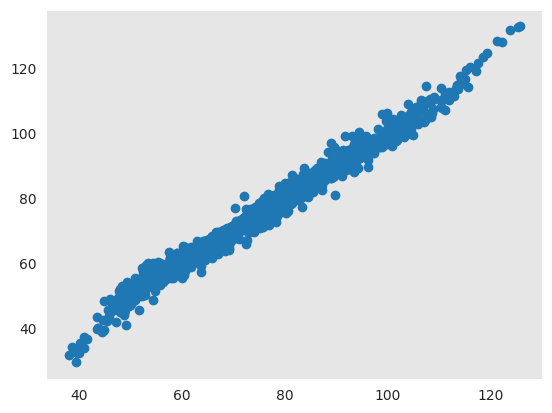

In [ ]:
plt.scatter(final_layer_output.values, second_layer_output.values)

#### **4.6.4 NeuralNetwork v3**

In [20]:
data.cat_features,data.num_features

(['Brand',
  'Material',
  'Size',
  'Compartments',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color',
  'cheap_flag',
  'expansive_flag'],
 ['Weight Capacity (kg)', 'TE_wc', 'skew_0', 'skew_1'])

In [21]:
data.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 int64  
 1   Material              int64  
 2   Size                  int64  
 3   Compartments          int64  
 4   Laptop Compartment    int64  
 5   Waterproof            int64  
 6   Style                 int64  
 7   Color                 int64  
 8   Weight Capacity (kg)  float64
 9   TE_wc                 float64
 10  skew_0                float64
 11  skew_1                float64
 12  cheap_flag            int64  
 13  expansive_flag        int64  
dtypes: float64(4), int64(10)
memory usage: 426.6 MB


In [27]:
class exitesqueeze_layer(layers.Layer):
    def __init__(self, exite_units,dropout_rate,activation,reg):
        super().__init__()

        self.exite_units = exite_units
        self.activation=activation
        self.reg=reg

        self.reshaped_0 = layers.Reshape((-1, 1))
        self.reshaped_1 = layers.Reshape((-1, ))

        self.exite = layers.Dense(self.exite_units, activation=self.activation)
        self.squeeze = layers.Dense(1, activation="linear",kernel_regularizer=keras.regularizers.l2(reg))
        self.lnorm_00 = layers.LayerNormalization()
        self.lnorm_01 = layers.LayerNormalization()
        self.drop = layers.Dropout(rate=dropout_rate)
        self.attention = layers.Attention()

    def call(self, inputs):
        x = self.reshaped_0(inputs)
        x = self.exite(x)
        att_out = self.attention([x,x])
        att_out = self.lnorm_00(att_out)
        x = layers.add([x, att_out])
        x = self.squeeze(x)
        x = self.reshaped_1(x)

        x = layers.multiply([x, inputs])

        x = self.lnorm_01(x)
        x = self.drop(x)

        return x

    # Remove build warnings
    def build(self):
        self.built = True

In [28]:
def build_model(units=512,exite_units=64, last_layer = 1, activation="relu", reg=0.001, dropout_rate=0.33):

    x_input_cats = layers.Input(shape=(len(data.cat_features),))
    embs = []
    for j in range(len(data.cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x_0 = layers.Concatenate(axis=-1, name="input_concat")(embs+[x_input_nums])

    es_0 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x_0)

    x = layers.Concatenate(axis=-1, name="se_0_concat")([x_0,es_0])
    x = layers.BatchNormalization(name="se_0_bn")(x)

    es_1 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_1_concat")([x,es_1])
    x = layers.BatchNormalization(name="se_1_bn")(x)

    es_2 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_2_concat")([x,es_2])
    x = layers.BatchNormalization(name="se_2_bn")(x)

    x_0 = layers.Dense(units, name="dense_0", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_0")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_0")(x_0)

    x_0 = layers.Dense(int(units/last_layer), name="dense_1", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_1")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_1")(x_0)

    x = layers.Concatenate(axis=-1)([x_0,x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

In [29]:
mod_test = build_model(units=64,exite_units=16, last_layer = 2, activation="relu", reg=0.001, dropout_rate=0.33)
mod_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_9 (GetItem)      │ (None)                 │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 3)              │             18 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 3)              │             15 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 2)              │              8 │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 4)              │             40 │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 2)              │              6 │ get_item_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 2)              │              6 │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 2)              │              8 │ get_item_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 3)              │             21 │ get_item_7[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embeddin

 Total params: 7,052 (27.55 KB)

 Trainable params: 6,048 (23.62 KB)

 Non-trainable params: 1,004 (3.92 KB)

In [ ]:
#plot_model(mod_test, show_shapes=True, show_dtype=True, show_layer_names=True, rankdir="TB")

In [ ]:
#t.cat_features_card,np.ceil(np.sqrt(t.cat_features_card)),len(t.cat_features)

##### 4.2.2 Optuna Optimization:

In [30]:
categorical_feat = data.cat_features.copy()
numerical_feat = data.num_features.copy()

X_train_cat = data.X[categorical_feat].astype("int32")
X_train_num = data.X[numerical_feat].astype("float32")

X_test_cat = data.X_test[categorical_feat].astype("int32")
X_test_num = data.X_test[numerical_feat].astype("float32")

X_train_cat.info()
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column              Dtype
---  ------              -----
 0   Brand               int32
 1   Material            int32
 2   Size                int32
 3   Compartments        int32
 4   Laptop Compartment  int32
 5   Waterproof          int32
 6   Style               int32
 7   Color               int32
 8   cheap_flag          int32
 9   expansive_flag      int32
dtypes: int32(10)
memory usage: 152.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 4 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Weight Capacity (kg)  float32
 1   TE_wc                 float32
 2   skew_0                float32
 3   skew_1                float32
dtypes: float32(4)
memory usage: 60.9 MB


In [31]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=build_model, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model
#(units=512,exite_units=64, last_layer = 1, activation="relu",  reg=0.001, dropout_rate=0.33)
    categorical_features = data.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'units': trial.suggest_categorical('units', [64,128,256]),#
              'last_layer': trial.suggest_int('last_layer',1,2),#
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_categorical('reg', [0.00001,0.0001,0.001,0.01]),
              "exite_units": trial.suggest_categorical('exite_units', [16,32,64]),#
              'dropout_rate': trial.suggest_float('dropout_rate', 0.30, 0.51,step=0.03)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        categorical_feat = data.cat_features.copy()
        numerical_feat = data.num_features.copy()

        X_train_cat = X_train[categorical_feat]
        X_train_num = X_train[numerical_feat]

        X_valid_cat = X_valid[categorical_feat]
        X_valid_num = X_valid[numerical_feat]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=1e-2)
        model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
                      metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=25,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, min_lr=0.00005),
                              keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmse",
                                                            start_from_epoch=3, mode="min")])

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)

        # Calculate the RMSE for the current fold
        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [34]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [35]:
cat_study = tune_hyperparameters(data.X, data.y, model_class=build_model, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=True)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

[I 2025-02-23 00:48:01,308] A new study created in memory with name: no-name-49cc8d06-a9d2-4b18-a629-5429ff0b69e4


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 89s 24ms/step - RMSE: 42.4820 - loss: 1849.0151 - val_RMSE: 38.6950 - val_loss: 1497.3987 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7643 - loss: 1502.7723 - val_RMSE: 38.6973 - val_loss: 1497.6093 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7584 - loss: 1502.3545 - val_RMSE: 38.7013 - val_loss: 1497.9435 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7337 - loss: 1500.4503 - val_RMSE: 38.6851 - val_loss: 1496.6754 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7285 - loss: 1500.0334 - val_RMSE: 38.6838 - val_loss: 1496.5654 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7267 - loss: 1499.8818 - val_RMSE: 38.6836 - val_loss: 1496.5461 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/s

[I 2025-02-23 01:37:20,570] Trial 0 finished with value: 38.696710393788 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'relu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.3}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 106s 29ms/step - RMSE: 42.8164 - loss: 1882.1709 - val_RMSE: 38.7010 - val_loss: 1497.8066 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7621 - loss: 1502.5391 - val_RMSE: 38.7258 - val_loss: 1499.7379 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7587 - loss: 1502.2994 - val_RMSE: 38.6948 - val_loss: 1497.3663 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7572 - loss: 1502.2126 - val_RMSE: 38.7404 - val_loss: 1500.9222 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7552 - loss: 1502.0767 - val_RMSE: 38.6933 - val_loss: 1497.2971 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7546 - loss: 1502.0524 - val_RMSE: 38.6903 - val_loss: 1497.0726 - learning_rate: 0.0100
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE:

[I 2025-02-23 02:40:56,141] Trial 1 finished with value: 38.69827949014242 and parameters: {'units': 64, 'last_layer': 2, 'activation': 'relu', 'reg': 0.0001, 'exite_units': 64, 'dropout_rate': 0.32999999999999996}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - RMSE: 42.2698 - loss: 1827.8013 - val_RMSE: 38.7159 - val_loss: 1498.9497 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - RMSE: 38.7686 - loss: 1503.0403 - val_RMSE: 38.7155 - val_loss: 1498.9373 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - RMSE: 38.7599 - loss: 1502.3832 - val_RMSE: 38.7054 - val_loss: 1498.1785 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7571 - loss: 1502.1864 - val_RMSE: 38.6970 - val_loss: 1497.5791 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7573 - loss: 1502.2693 - val_RMSE: 38.6962 - val_loss: 1497.5505 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7547 - loss: 1502.0929 - val_RMSE: 38.6913 - val_loss: 1497.1942 - learning_rate: 0.0100
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 

[I 2025-02-23 03:31:36,391] Trial 2 finished with value: 38.69746866921932 and parameters: {'units': 256, 'last_layer': 1, 'activation': 'selu', 'reg': 1e-05, 'exite_units': 16, 'dropout_rate': 0.32999999999999996}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step - RMSE: 42.5331 - loss: 1857.6256 - val_RMSE: 38.7029 - val_loss: 1498.8004 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7660 - loss: 1503.6312 - val_RMSE: 38.7071 - val_loss: 1498.9594 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7629 - loss: 1503.1954 - val_RMSE: 38.7172 - val_loss: 1499.3317 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7423 - loss: 1501.1727 - val_RMSE: 38.6924 - val_loss: 1497.2329 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - RMSE: 38.7370 - loss: 1500.6921 - val_RMSE: 38.6907 - val_loss: 1497.1075 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - RMSE: 38.7354 - loss: 1500.5786 - val_RMSE: 38.6886 - val_loss: 1497.0002 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/s

[I 2025-02-23 04:39:30,347] Trial 3 finished with value: 38.70071321047837 and parameters: {'units': 256, 'last_layer': 2, 'activation': 'silu', 'reg': 0.01, 'exite_units': 64, 'dropout_rate': 0.44999999999999996}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - RMSE: 42.5152 - loss: 1855.0037 - val_RMSE: 38.6971 - val_loss: 1498.1749 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7645 - loss: 1503.4374 - val_RMSE: 38.7003 - val_loss: 1498.4285 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7620 - loss: 1503.0951 - val_RMSE: 38.6982 - val_loss: 1497.8918 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7609 - loss: 1502.8010 - val_RMSE: 38.6993 - val_loss: 1498.0414 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7604 - loss: 1502.7922 - val_RMSE: 38.7367 - val_loss: 1500.6361 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RMSE: 38.7402 - loss: 1500.8724 - val_RMSE: 38.6923 - val_loss: 1497.1276 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - RM

[I 2025-02-23 05:42:18,563] Trial 4 finished with value: 38.703210553627535 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'relu', 'reg': 0.01, 'exite_units': 64, 'dropout_rate': 0.42}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 85s 26ms/step - RMSE: 42.8359 - loss: 1884.2311 - val_RMSE: 38.6991 - val_loss: 1497.8054 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7621 - loss: 1502.6879 - val_RMSE: 38.7360 - val_loss: 1500.6530 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7608 - loss: 1502.5908 - val_RMSE: 38.6965 - val_loss: 1497.6302 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7592 - loss: 1502.4574 - val_RMSE: 38.7141 - val_loss: 1498.9359 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7595 - loss: 1502.4913 - val_RMSE: 38.7001 - val_loss: 1497.8936 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7400 - loss: 1500.9700 - val_RMSE: 38.6891 - val_loss: 1496.9796 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - RM

[I 2025-02-23 06:50:44,443] Trial 5 finished with value: 38.70159366861271 and parameters: {'units': 64, 'last_layer': 2, 'activation': 'selu', 'reg': 0.001, 'exite_units': 64, 'dropout_rate': 0.39}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 88s 26ms/step - RMSE: 42.8238 - loss: 1882.8636 - val_RMSE: 38.6974 - val_loss: 1497.4934 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7601 - loss: 1502.3468 - val_RMSE: 38.7120 - val_loss: 1498.6277 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - RMSE: 38.7581 - loss: 1502.1991 - val_RMSE: 38.6949 - val_loss: 1497.3098 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - RMSE: 38.7573 - loss: 1502.1389 - val_RMSE: 38.6996 - val_loss: 1497.6754 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7560 - loss: 1502.0472 - val_RMSE: 38.7039 - val_loss: 1498.0144 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7350 - loss: 1500.4221 - val_RMSE: 38.6852 - val_loss: 1496.5675 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RM

[I 2025-02-23 07:59:21,449] Trial 6 finished with value: 38.69884438684419 and parameters: {'units': 64, 'last_layer': 2, 'activation': 'gelu', 'reg': 1e-05, 'exite_units': 64, 'dropout_rate': 0.42}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - RMSE: 42.5193 - loss: 1852.4968 - val_RMSE: 38.6972 - val_loss: 1497.4923 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - RMSE: 38.7633 - loss: 1502.6157 - val_RMSE: 38.7080 - val_loss: 1498.3389 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7582 - loss: 1502.2375 - val_RMSE: 38.7092 - val_loss: 1498.4543 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7337 - loss: 1500.3571 - val_RMSE: 38.6840 - val_loss: 1496.5054 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7282 - loss: 1499.9219 - val_RMSE: 38.6832 - val_loss: 1496.4414 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - RMSE: 38.7260 - loss: 1499.7520 - val_RMSE: 38.6827 - val_loss: 1496.4021 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/s

[I 2025-02-23 08:47:50,991] Trial 7 finished with value: 38.69705476562388 and parameters: {'units': 256, 'last_layer': 2, 'activation': 'relu', 'reg': 1e-05, 'exite_units': 16, 'dropout_rate': 0.42}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - RMSE: 42.8132 - loss: 1881.8291 - val_RMSE: 38.6952 - val_loss: 1497.3544 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - RMSE: 38.7608 - loss: 1502.4475 - val_RMSE: 38.7217 - val_loss: 1499.4329 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7594 - loss: 1502.3654 - val_RMSE: 38.7167 - val_loss: 1499.0803 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7344 - loss: 1500.4436 - val_RMSE: 38.6851 - val_loss: 1496.6221 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7296 - loss: 1500.0714 - val_RMSE: 38.6862 - val_loss: 1496.7089 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - RMSE: 38.7279 - loss: 1499.9352 - val_RMSE: 38.6843 - val_loss: 1496.5609 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/s

[I 2025-02-23 09:56:13,165] Trial 8 finished with value: 38.698128415832144 and parameters: {'units': 64, 'last_layer': 2, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 64, 'dropout_rate': 0.36}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - RMSE: 42.7173 - loss: 1873.8325 - val_RMSE: 38.7139 - val_loss: 1499.1440 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7637 - loss: 1502.9199 - val_RMSE: 38.6987 - val_loss: 1497.7234 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - RMSE: 38.7624 - loss: 1502.6368 - val_RMSE: 38.7074 - val_loss: 1498.2804 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - RMSE: 38.7597 - loss: 1502.3391 - val_RMSE: 38.7032 - val_loss: 1498.1995 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7406 - loss: 1500.9136 - val_RMSE: 38.6931 - val_loss: 1497.1761 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - RMSE: 38.7366 - loss: 1500.5479 - val_RMSE: 38.6921 - val_loss: 1497.1167 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step 

[I 2025-02-23 10:44:33,607] Trial 9 finished with value: 38.70537030317054 and parameters: {'units': 128, 'last_layer': 2, 'activation': 'selu', 'reg': 0.01, 'exite_units': 16, 'dropout_rate': 0.44999999999999996}. Best is trial 0 with value: 38.696710393788.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - RMSE: 42.5453 - loss: 1854.9423 - val_RMSE: 38.6972 - val_loss: 1497.5632 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7627 - loss: 1502.6490 - val_RMSE: 38.6943 - val_loss: 1497.3860 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - RMSE: 38.7600 - loss: 1502.4985 - val_RMSE: 38.6998 - val_loss: 1497.8654 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - RMSE: 38.7583 - loss: 1502.4227 - val_RMSE: 38.7016 - val_loss: 1498.1123 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - RMSE: 38.7360 - loss: 1500.7708 - val_RMSE: 38.6850 - val_loss: 1496.7909 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - RMSE: 38.7305 - loss: 1500.3047 - val_RMSE: 38.6840 - val_loss: 1496.6688 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step 

[I 2025-02-23 11:41:25,962] Trial 10 finished with value: 38.69639193901346 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.51}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - RMSE: 42.5454 - loss: 1854.9484 - val_RMSE: 38.7009 - val_loss: 1497.8472 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7630 - loss: 1502.6708 - val_RMSE: 38.7061 - val_loss: 1498.3007 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7593 - loss: 1502.4410 - val_RMSE: 38.7013 - val_loss: 1497.9832 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7357 - loss: 1500.6432 - val_RMSE: 38.6858 - val_loss: 1496.7700 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7308 - loss: 1500.2440 - val_RMSE: 38.6850 - val_loss: 1496.6818 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7289 - loss: 1500.0743 - val_RMSE: 38.6842 - val_loss: 1496.6123 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/s

[I 2025-02-23 12:39:06,721] Trial 11 finished with value: 38.697016951832914 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.51}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - RMSE: 42.5454 - loss: 1854.9471 - val_RMSE: 38.6995 - val_loss: 1497.7373 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7627 - loss: 1502.6493 - val_RMSE: 38.6971 - val_loss: 1497.6045 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7592 - loss: 1502.4337 - val_RMSE: 38.7496 - val_loss: 1501.7234 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7583 - loss: 1502.4194 - val_RMSE: 38.7543 - val_loss: 1502.1705 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7362 - loss: 1500.7649 - val_RMSE: 38.6852 - val_loss: 1496.7837 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7308 - loss: 1500.3091 - val_RMSE: 38.6849 - val_loss: 1496.7288 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step 

[I 2025-02-23 13:36:03,173] Trial 12 finished with value: 38.69689101585856 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.51}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - RMSE: 42.4840 - loss: 1849.2191 - val_RMSE: 38.6934 - val_loss: 1497.2781 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7648 - loss: 1502.8129 - val_RMSE: 38.7082 - val_loss: 1498.4542 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7573 - loss: 1502.2740 - val_RMSE: 38.6985 - val_loss: 1497.7383 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7313 - loss: 1500.2755 - val_RMSE: 38.6825 - val_loss: 1496.4785 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7261 - loss: 1499.8523 - val_RMSE: 38.6816 - val_loss: 1496.3989 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7243 - loss: 1499.7042 - val_RMSE: 38.6818 - val_loss: 1496.4041 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/s

[I 2025-02-23 14:34:32,143] Trial 13 finished with value: 38.69649960900768 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.3}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - RMSE: 42.5287 - loss: 1853.8055 - val_RMSE: 38.7054 - val_loss: 1498.5800 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7630 - loss: 1503.0297 - val_RMSE: 38.6975 - val_loss: 1497.9768 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7657 - loss: 1503.3575 - val_RMSE: 38.7002 - val_loss: 1498.6407 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7660 - loss: 1503.6688 - val_RMSE: 38.7020 - val_loss: 1498.3610 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7356 - loss: 1500.9191 - val_RMSE: 38.6849 - val_loss: 1496.8853 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7299 - loss: 1500.3511 - val_RMSE: 38.6835 - val_loss: 1496.7177 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step 

[I 2025-02-23 15:32:16,743] Trial 14 finished with value: 38.6969810338204 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.001, 'exite_units': 32, 'dropout_rate': 0.48}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - RMSE: 42.4857 - loss: 1849.3625 - val_RMSE: 38.6971 - val_loss: 1497.5635 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7649 - loss: 1502.8230 - val_RMSE: 38.7054 - val_loss: 1498.2340 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7576 - loss: 1502.2932 - val_RMSE: 38.7002 - val_loss: 1497.8624 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7315 - loss: 1500.2834 - val_RMSE: 38.6832 - val_loss: 1496.5336 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - RMSE: 38.7269 - loss: 1499.9165 - val_RMSE: 38.6823 - val_loss: 1496.4458 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7257 - loss: 1499.8042 - val_RMSE: 38.6819 - val_loss: 1496.4099 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/s

[I 2025-02-23 16:30:50,070] Trial 15 finished with value: 38.697166689195434 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.3}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 77s 23ms/step - RMSE: 42.4981 - loss: 1850.5037 - val_RMSE: 38.6963 - val_loss: 1497.5016 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7623 - loss: 1502.6176 - val_RMSE: 38.7209 - val_loss: 1499.4478 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7574 - loss: 1502.2920 - val_RMSE: 38.6940 - val_loss: 1497.4031 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7550 - loss: 1502.1379 - val_RMSE: 38.7279 - val_loss: 1500.0826 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7554 - loss: 1502.2418 - val_RMSE: 38.6965 - val_loss: 1497.6833 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7317 - loss: 1500.4010 - val_RMSE: 38.6830 - val_loss: 1496.6028 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RM

[I 2025-02-23 17:29:30,938] Trial 16 finished with value: 38.696688941023034 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - RMSE: 42.5283 - loss: 1853.3069 - val_RMSE: 38.7070 - val_loss: 1498.3182 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - RMSE: 38.7635 - loss: 1502.7095 - val_RMSE: 38.7113 - val_loss: 1498.7063 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7589 - loss: 1502.4154 - val_RMSE: 38.7004 - val_loss: 1497.9165 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7574 - loss: 1502.3427 - val_RMSE: 38.7119 - val_loss: 1498.8721 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7580 - loss: 1502.4866 - val_RMSE: 38.6895 - val_loss: 1497.2085 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7575 - loss: 1502.4888 - val_RMSE: 38.7197 - val_loss: 1499.5643 - learning_rate: 0.0100
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 

[I 2025-02-23 18:27:55,817] Trial 17 finished with value: 38.69696801004246 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.48}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - RMSE: 42.5061 - loss: 1851.7075 - val_RMSE: 38.6990 - val_loss: 1498.0698 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7645 - loss: 1503.0989 - val_RMSE: 38.6957 - val_loss: 1497.7089 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7588 - loss: 1502.6493 - val_RMSE: 38.6955 - val_loss: 1497.7131 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7568 - loss: 1502.4940 - val_RMSE: 38.6979 - val_loss: 1497.8549 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7350 - loss: 1500.7108 - val_RMSE: 38.6850 - val_loss: 1496.7921 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7293 - loss: 1500.2126 - val_RMSE: 38.6837 - val_loss: 1496.6650 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step 

[I 2025-02-23 19:25:47,956] Trial 18 finished with value: 38.696786141502315 and parameters: {'units': 128, 'last_layer': 1, 'activation': 'gelu', 'reg': 0.001, 'exite_units': 32, 'dropout_rate': 0.39}. Best is trial 10 with value: 38.69639193901346.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - RMSE: 42.2596 - loss: 1826.8907 - val_RMSE: 38.7030 - val_loss: 1498.1605 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7667 - loss: 1503.0985 - val_RMSE: 38.7197 - val_loss: 1499.4653 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7578 - loss: 1502.4265 - val_RMSE: 38.7032 - val_loss: 1498.1886 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7325 - loss: 1500.4470 - val_RMSE: 38.6839 - val_loss: 1496.6523 - learning_rate: 1.0000e-03
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7279 - loss: 1500.0575 - val_RMSE: 38.6838 - val_loss: 1496.6176 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7261 - loss: 1499.8948 - val_RMSE: 38.6824 - val_loss: 1496.5101 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/s

[I 2025-02-23 20:23:05,143] Trial 19 finished with value: 38.69609437218236 and parameters: {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}. Best is trial 19 with value: 38.69609437218236.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - RMSE: 42.2576 - loss: 1826.7124 - val_RMSE: 38.7088 - val_loss: 1498.6077 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7666 - loss: 1503.0922 - val_RMSE: 38.6959 - val_loss: 1497.6295 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7582 - loss: 1502.4547 - val_RMSE: 38.6998 - val_loss: 1497.9158 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7563 - loss: 1502.3163 - val_RMSE: 38.7285 - val_loss: 1500.3530 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - RMSE: 38.7335 - loss: 1500.7147 - val_RMSE: 38.6838 - val_loss: 1496.7849 - learning_rate: 1.0000e-03
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - RMSE: 38.7282 - loss: 1500.2028 - val_RMSE: 38.6832 - val_loss: 1496.6654 - learning_rate: 1.0000e-03
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step 

[I 2025-02-23 21:20:29,865] Trial 20 finished with value: 38.69650599915822 and parameters: {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}. Best is trial 19 with value: 38.69609437218236.


Epoch 1/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - RMSE: 42.2441 - loss: 1825.4763 - val_RMSE: 38.7147 - val_loss: 1499.0643 - learning_rate: 0.0100
Epoch 2/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7674 - loss: 1503.1533 - val_RMSE: 38.7027 - val_loss: 1498.1351 - learning_rate: 0.0100
Epoch 3/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - RMSE: 38.7575 - loss: 1502.3794 - val_RMSE: 38.7063 - val_loss: 1498.3782 - learning_rate: 0.0100
Epoch 4/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7555 - loss: 1502.2064 - val_RMSE: 38.6996 - val_loss: 1497.9674 - learning_rate: 0.0100
Epoch 5/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7543 - loss: 1502.2875 - val_RMSE: 38.6910 - val_loss: 1497.4161 - learning_rate: 0.0100
Epoch 6/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 38.7533 - loss: 1502.2555 - val_RMSE: 38.6973 - val_loss: 1497.9465 - learning_rate: 0.0100
Epoch 7/25
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - RMSE: 

[W 2025-02-23 21:30:03,040] Trial 21 failed with parameters: {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.32999999999999996} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-34-1f75ff93dfcb>", line 4, in <lambda>
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-31-92b760355d9d>", line 52, in objective_nn
    model.fit([X_train_cat,X_train_num], y_train,
  File "/usr/local/lib/python3.11/dist-pack

KeyboardInterrupt: 

- Trial 19 finished with value: 38.69609437218236
- parameters: {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}.